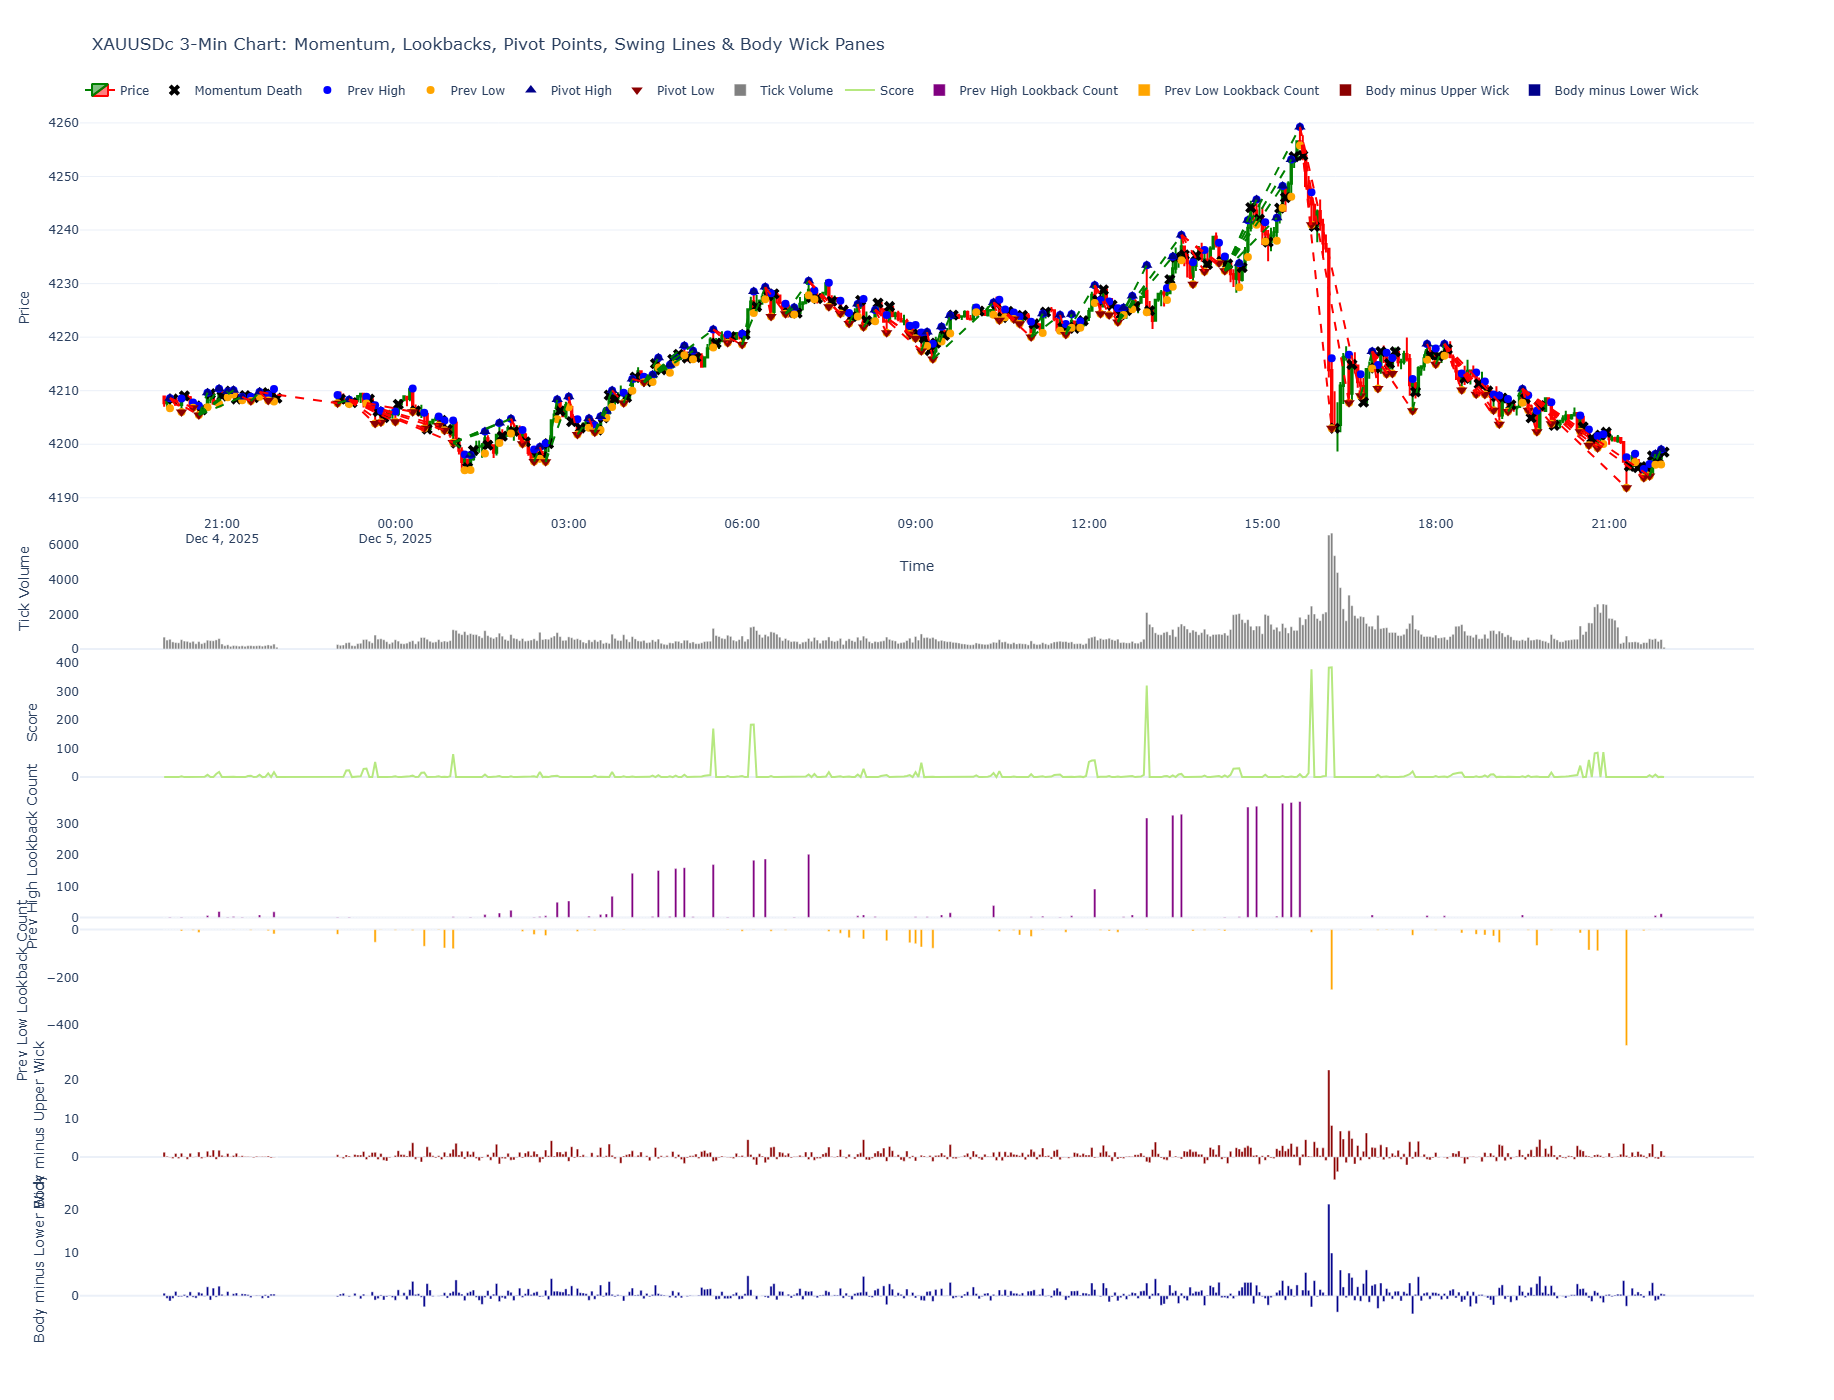

In [3]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# Remove non-trading periods (weekends)
df = df[df.index.dayofweek < 5]

# -------------------------
# 4. Compute Infinite Lookback Score (momentum)
# -------------------------
scores = [0]
for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1
    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break
    scores.append(score)

df['score'] = scores

# -------------------------
# 5. Detect Momentum Death Points and prev high/low marks
# -------------------------
momentum_death_x = []
momentum_death_y = []
prev_high_x = []
prev_high_y = []
prev_low_x = []
prev_low_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:
        momentum_death_x.append(df.index[i])
        momentum_death_y.append(df['close'].iloc[i])
        prev_high_x.append(df.index[i - 1])
        prev_high_y.append(df['high'].iloc[i - 1])
        prev_low_x.append(df.index[i - 1])
        prev_low_y.append(df['low'].iloc[i - 1])

# -------------------------
# 6. Compute Infinite-Left Lookback Count for Prev High
# -------------------------
prev_high_lookback_score = np.zeros(len(df))
prev_high_indices = [df.index.get_loc(x) for x in prev_high_x]

for idx in prev_high_indices:
    current_high = df['high'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_high <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_high_lookback_score[idx] = lookback_count

df['prev_high_lookback_score'] = prev_high_lookback_score

# -------------------------
# 7. Compute Infinite-Left Lookback Count for Prev Low (negative)
# -------------------------
prev_low_lookback_score = np.zeros(len(df))
prev_low_indices = [df.index.get_loc(x) for x in prev_low_x]

for idx in prev_low_indices:
    current_low = df['low'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_low <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_low_lookback_score[idx] = -lookback_count

df['prev_low_lookback_score'] = prev_low_lookback_score

# -------------------------
# 8. Determine Pivot Highs and Lows
# -------------------------
pivot_high_x = []
pivot_high_y = []
pivot_low_x = []
pivot_low_y = []

for i in range(len(df)):
    ph_score = df['prev_high_lookback_score'].iloc[i]
    pl_score = abs(df['prev_low_lookback_score'].iloc[i])

    if ph_score > pl_score and ph_score != 0:
        pivot_high_x.append(df.index[i])
        pivot_high_y.append(df['high'].iloc[i])
    elif pl_score > ph_score and pl_score != 0:
        pivot_low_x.append(df.index[i])
        pivot_low_y.append(df['low'].iloc[i])

# -------------------------
# 9. Connect Pivot Points with Break Lines
# -------------------------
swing_lines = []

pivot_points = sorted(
    [(x, y, 'high') for x, y in zip(pivot_high_x, pivot_high_y)] +
    [(x, y, 'low') for x, y in zip(pivot_low_x, pivot_low_y)],
    key=lambda t: t[0]
)

for i in range(len(pivot_points)):
    curr_time, curr_price, curr_type = pivot_points[i]

    # Search backward for opposite pivot
    for j in range(i - 1, -1, -1):
        prev_time, prev_price, prev_type = pivot_points[j]
        if prev_type != curr_type:
            line_color = 'green' if curr_type == 'high' else 'red'
            swing_lines.append({
                'x0': prev_time, 'y0': prev_price,
                'x1': curr_time, 'y1': curr_price,
                'color': line_color
            })
            break

# -------------------------
# 10. Body / Wick Calculations (Body-Upper and Body-Lower Panes)
# -------------------------
df['body'] = abs(df['close'] - df['open'])
df['upper_wick'] = df['high'] - df[['open','close']].max(axis=1)
df['lower_wick'] = df[['open','close']].min(axis=1) - df['low']
df['body_minus_upper'] = df['body'] - df['upper_wick']
df['body_minus_lower'] = df['body'] - df['lower_wick']

# -------------------------
# 11. Plot 7-pane chart
# -------------------------
fig = go.Figure()

# Price pane
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='Price',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum-death markers
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Prev high/low circles
fig.add_trace(go.Scatter(
    x=prev_high_x,
    y=prev_high_y,
    mode='markers',
    name='Prev High',
    marker=dict(size=8, color='blue', symbol='circle'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=prev_low_x,
    y=prev_low_y,
    mode='markers',
    name='Prev Low',
    marker=dict(size=8, color='orange', symbol='circle'),
    yaxis='y'
))

# Pivot markers
fig.add_trace(go.Scatter(
    x=pivot_high_x,
    y=pivot_high_y,
    mode='markers',
    name='Pivot High',
    marker=dict(size=10, color='darkblue', symbol='triangle-up'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=pivot_low_x,
    y=pivot_low_y,
    mode='markers',
    name='Pivot Low',
    marker=dict(size=10, color='darkred', symbol='triangle-down'),
    yaxis='y'
))

# Add swing/break lines
for line in swing_lines:
    fig.add_shape(
        type='line',
        x0=line['x0'], y0=line['y0'],
        x1=line['x1'], y1=line['y1'],
        line=dict(color=line['color'], width=2, dash='dash'),
        xref='x', yref='y'
    )

# Tick Volume pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Momentum score pane
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Prev High Lookback Count pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_high_lookback_score'],
    name='Prev High Lookback Count',
    marker_color='purple',
    yaxis='y4'
))

# Prev Low Lookback Count pane (negative)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_low_lookback_score'],
    name='Prev Low Lookback Count',
    marker_color='orange',
    yaxis='y5'
))

# Body minus Upper Wick pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_upper'],
    name='Body minus Upper Wick',
    marker_color='darkred',
    yaxis='y6'
))

# Body minus Lower Wick pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_lower'],
    name='Body minus Lower Wick',
    marker_color='darkblue',
    yaxis='y7'
))

# Layout for 7 panes
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Min Chart: Momentum, Lookbacks, Pivot Points, Swing Lines & Body Wick Panes',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price', domain=[0.66, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.55, 0.65], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.44, 0.54], showgrid=False),
    yaxis4=dict(title='Prev High Lookback Count', domain=[0.33, 0.43], showgrid=False),
    yaxis5=dict(title='Prev Low Lookback Count', domain=[0.22, 0.32], showgrid=False),
    yaxis6=dict(title='Body minus Upper Wick', domain=[0.11, 0.21], showgrid=False),
    yaxis7=dict(title='Body minus Lower Wick', domain=[0.00, 0.10], showgrid=False),

    height=1400,
    legend=dict(orientation='h', y=1.02, x=0)
)

fig.show()


only mark 'Momentum death' if the corresponding candlestick has 'body-upper' AND 'body-lower' positive values

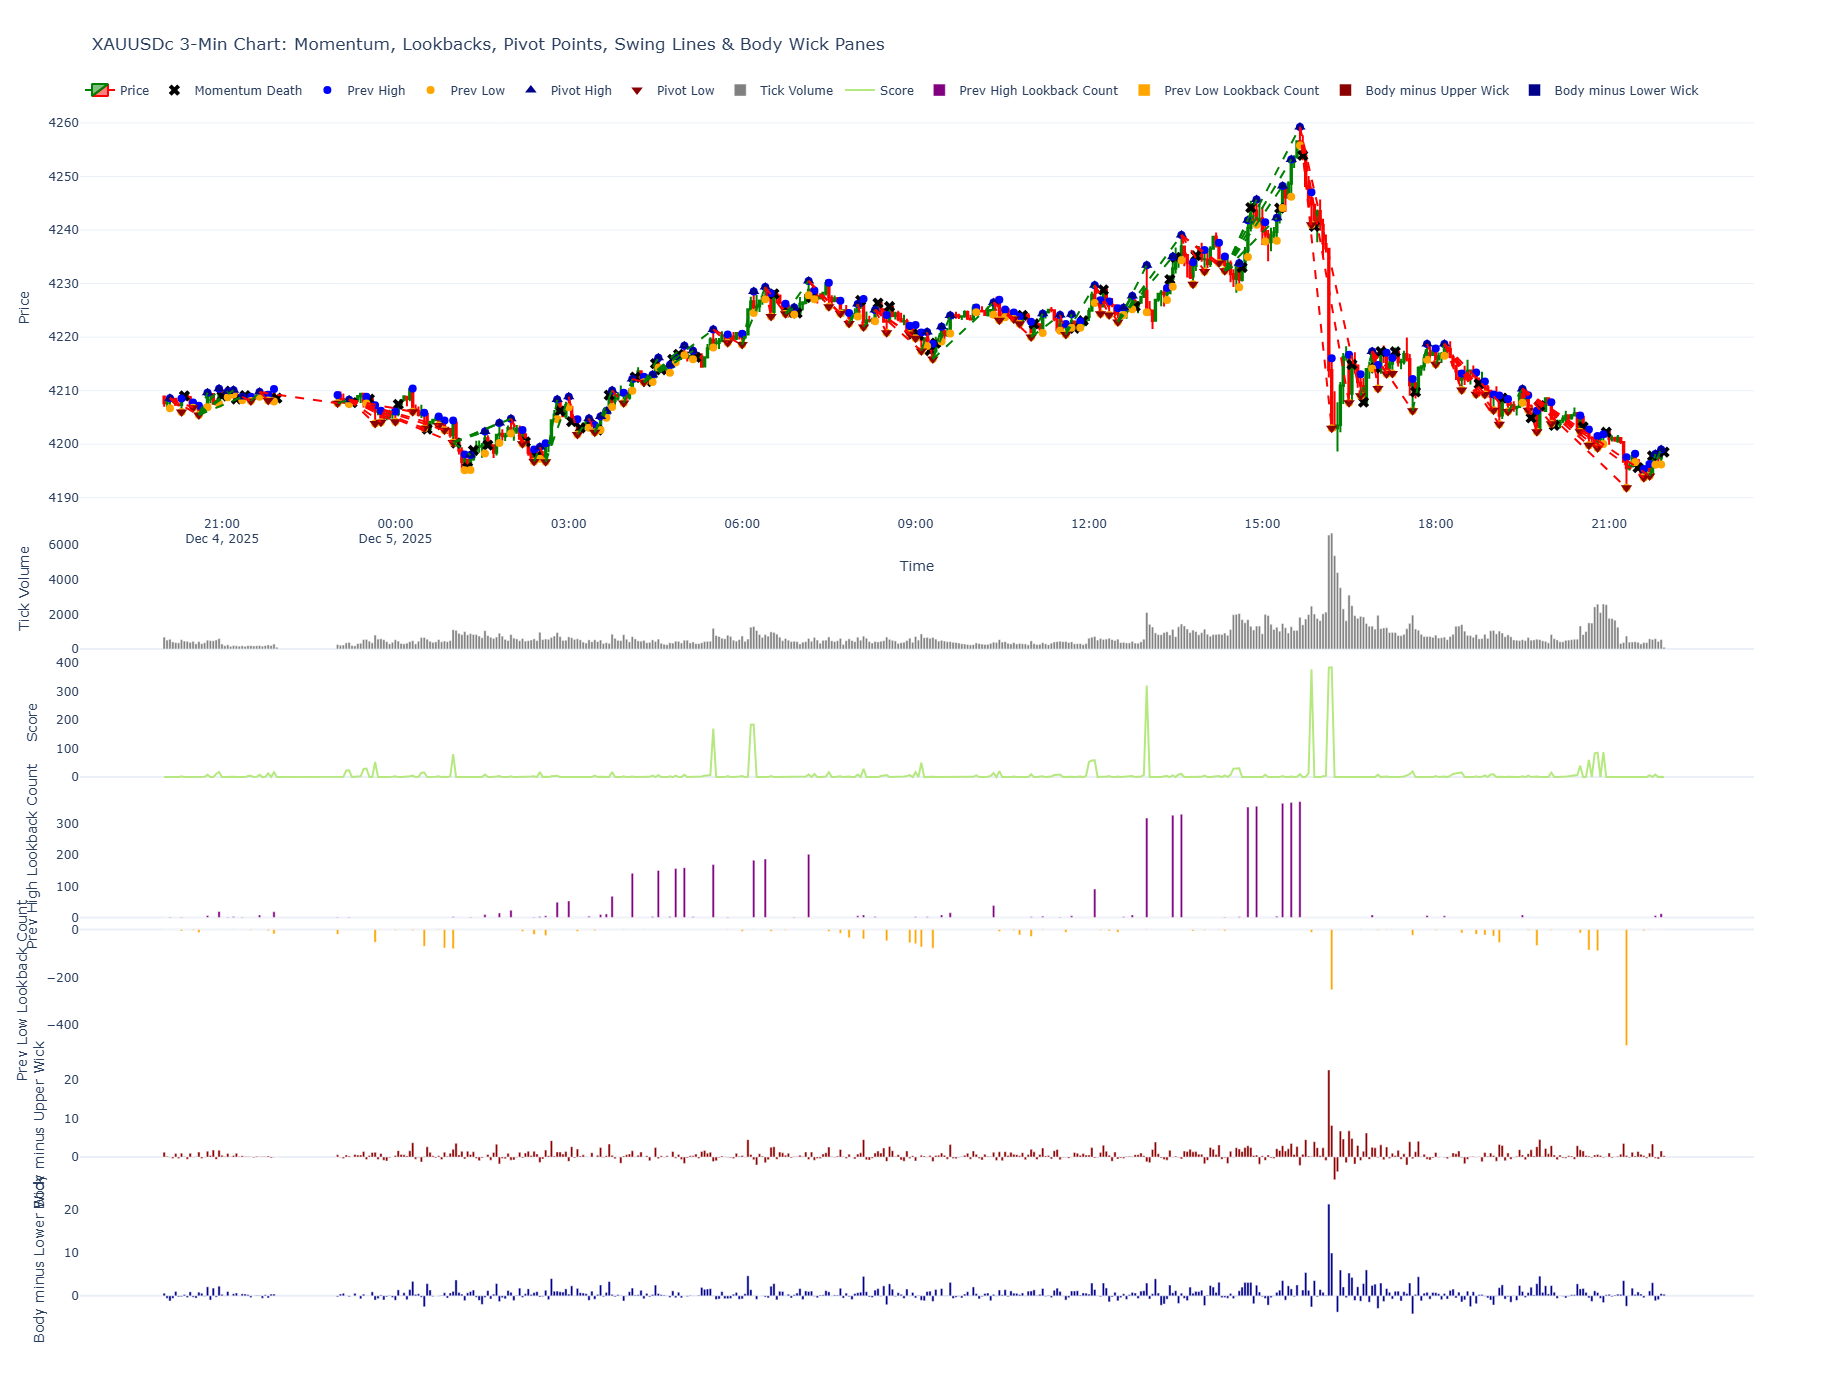

In [4]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df[df.index.dayofweek < 5]

# -------------------------
# 4. Body / Wick Calculations (for Body-Upper and Body-Lower panes)
# -------------------------
df['body'] = abs(df['close'] - df['open'])
df['upper_wick'] = df['high'] - df[['open','close']].max(axis=1)
df['lower_wick'] = df[['open','close']].min(axis=1) - df['low']
df['body_minus_upper'] = df['body'] - df['upper_wick']
df['body_minus_lower'] = df['body'] - df['lower_wick']

# -------------------------
# 5. Compute Infinite Lookback Score (momentum)
# -------------------------
scores = [0]
for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1
    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break
    scores.append(score)

df['score'] = scores

# -------------------------
# 6. Detect Momentum Death Points (only if body-minus-upper and body-minus-lower positive)
# -------------------------
momentum_death_x = []
momentum_death_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:
        if df['body_minus_upper'].iloc[i] > 0 and df['body_minus_lower'].iloc[i] > 0:
            momentum_death_x.append(df.index[i])
            momentum_death_y.append(df['close'].iloc[i])

# -------------------------
# 7. Detect prev high/low marks
# -------------------------
prev_high_x = []
prev_high_y = []
prev_low_x = []
prev_low_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:
        prev_high_x.append(df.index[i - 1])
        prev_high_y.append(df['high'].iloc[i - 1])
        prev_low_x.append(df.index[i - 1])
        prev_low_y.append(df['low'].iloc[i - 1])

# -------------------------
# 8. Compute Infinite-Left Lookback Count for Prev High
# -------------------------
prev_high_lookback_score = np.zeros(len(df))
prev_high_indices = [df.index.get_loc(x) for x in prev_high_x]

for idx in prev_high_indices:
    current_high = df['high'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_high <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_high_lookback_score[idx] = lookback_count

df['prev_high_lookback_score'] = prev_high_lookback_score

# -------------------------
# 9. Compute Infinite-Left Lookback Count for Prev Low (negative)
# -------------------------
prev_low_lookback_score = np.zeros(len(df))
prev_low_indices = [df.index.get_loc(x) for x in prev_low_x]

for idx in prev_low_indices:
    current_low = df['low'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_low <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_low_lookback_score[idx] = -lookback_count

df['prev_low_lookback_score'] = prev_low_lookback_score

# -------------------------
# 10. Determine Pivot Highs and Lows
# -------------------------
pivot_high_x = []
pivot_high_y = []
pivot_low_x = []
pivot_low_y = []

for i in range(len(df)):
    ph_score = df['prev_high_lookback_score'].iloc[i]
    pl_score = abs(df['prev_low_lookback_score'].iloc[i])

    if ph_score > pl_score and ph_score != 0:
        pivot_high_x.append(df.index[i])
        pivot_high_y.append(df['high'].iloc[i])
    elif pl_score > ph_score and pl_score != 0:
        pivot_low_x.append(df.index[i])
        pivot_low_y.append(df['low'].iloc[i])

# -------------------------
# 11. Connect Pivot Points with Break Lines
# -------------------------
swing_lines = []

pivot_points = sorted(
    [(x, y, 'high') for x, y in zip(pivot_high_x, pivot_high_y)] +
    [(x, y, 'low') for x, y in zip(pivot_low_x, pivot_low_y)],
    key=lambda t: t[0]
)

for i in range(len(pivot_points)):
    curr_time, curr_price, curr_type = pivot_points[i]

    for j in range(i - 1, -1, -1):
        prev_time, prev_price, prev_type = pivot_points[j]
        if prev_type != curr_type:
            line_color = 'green' if curr_type == 'high' else 'red'
            swing_lines.append({
                'x0': prev_time, 'y0': prev_price,
                'x1': curr_time, 'y1': curr_price,
                'color': line_color
            })
            break

# -------------------------
# 12. Plot 7-pane chart
# -------------------------
fig = go.Figure()

# Price pane
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='Price',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum-death markers
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Prev high/low circles
fig.add_trace(go.Scatter(
    x=prev_high_x,
    y=prev_high_y,
    mode='markers',
    name='Prev High',
    marker=dict(size=8, color='blue', symbol='circle'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=prev_low_x,
    y=prev_low_y,
    mode='markers',
    name='Prev Low',
    marker=dict(size=8, color='orange', symbol='circle'),
    yaxis='y'
))

# Pivot markers
fig.add_trace(go.Scatter(
    x=pivot_high_x,
    y=pivot_high_y,
    mode='markers',
    name='Pivot High',
    marker=dict(size=10, color='darkblue', symbol='triangle-up'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=pivot_low_x,
    y=pivot_low_y,
    mode='markers',
    name='Pivot Low',
    marker=dict(size=10, color='darkred', symbol='triangle-down'),
    yaxis='y'
))

# Add swing/break lines
for line in swing_lines:
    fig.add_shape(
        type='line',
        x0=line['x0'], y0=line['y0'],
        x1=line['x1'], y1=line['y1'],
        line=dict(color=line['color'], width=2, dash='dash'),
        xref='x', yref='y'
    )

# Tick Volume pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Momentum score pane
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Prev High Lookback Count pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_high_lookback_score'],
    name='Prev High Lookback Count',
    marker_color='purple',
    yaxis='y4'
))

# Prev Low Lookback Count pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_low_lookback_score'],
    name='Prev Low Lookback Count',
    marker_color='orange',
    yaxis='y5'
))

# Body minus Upper Wick pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_upper'],
    name='Body minus Upper Wick',
    marker_color='darkred',
    yaxis='y6'
))

# Body minus Lower Wick pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_lower'],
    name='Body minus Lower Wick',
    marker_color='darkblue',
    yaxis='y7'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Min Chart: Momentum, Lookbacks, Pivot Points, Swing Lines & Body Wick Panes',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price', domain=[0.66, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.55, 0.65], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.44, 0.54], showgrid=False),
    yaxis4=dict(title='Prev High Lookback Count', domain=[0.33, 0.43], showgrid=False),
    yaxis5=dict(title='Prev Low Lookback Count', domain=[0.22, 0.32], showgrid=False),
    yaxis6=dict(title='Body minus Upper Wick', domain=[0.11, 0.21], showgrid=False),
    yaxis7=dict(title='Body minus Lower Wick', domain=[0.00, 0.10], showgrid=False),

    height=1400,
    legend=dict(orientation='h', y=1.02, x=0)
)

fig.show()


In [ ]:
if no momentum death then there also no pivot points and no prev high or low points

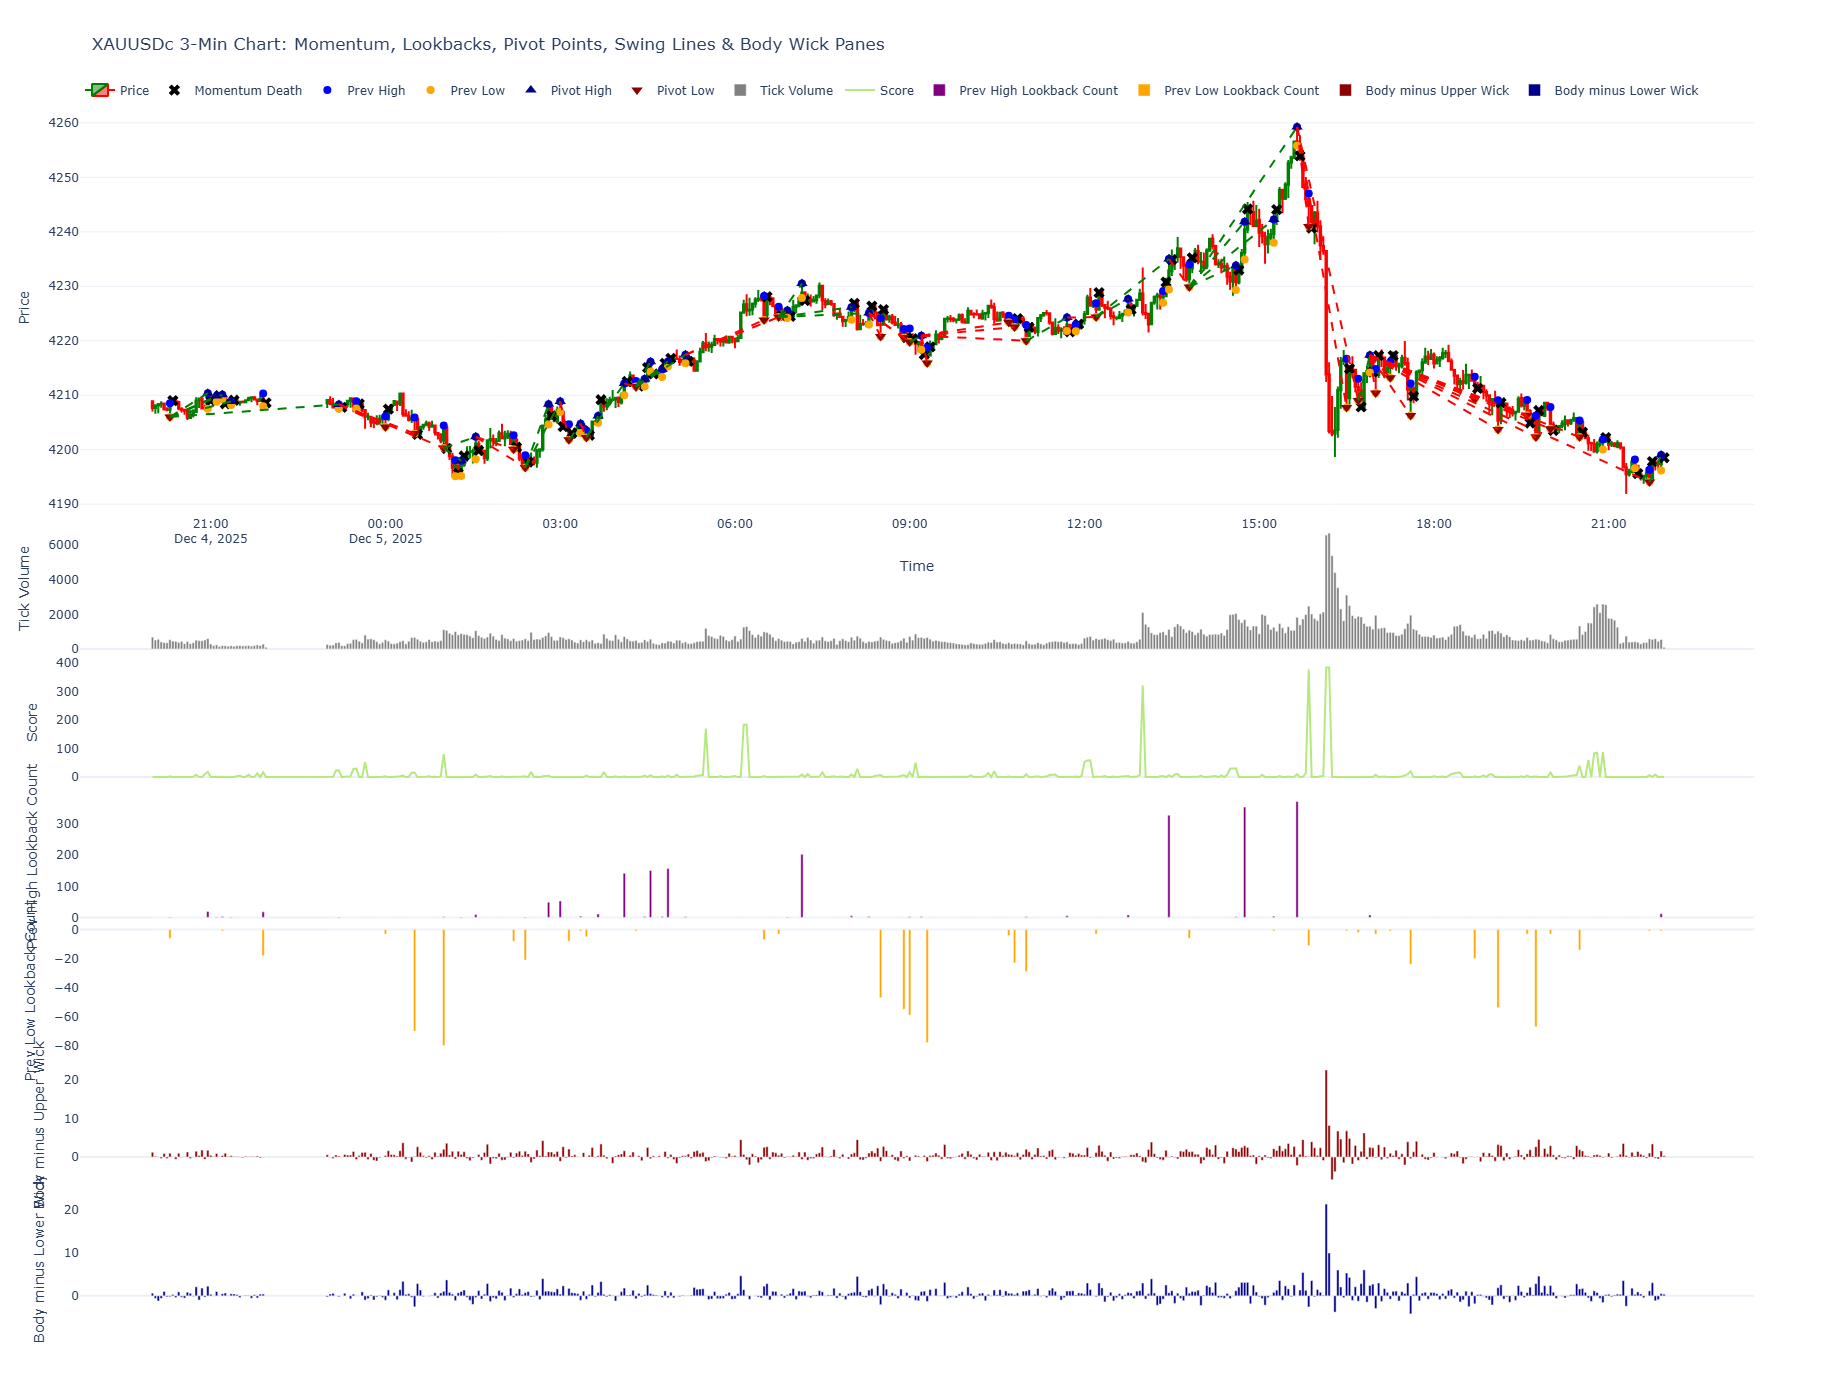

In [5]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df[df.index.dayofweek < 5]

# -------------------------
# 4. Body / Wick Calculations (Body-Upper and Body-Lower panes)
# -------------------------
df['body'] = abs(df['close'] - df['open'])
df['upper_wick'] = df['high'] - df[['open','close']].max(axis=1)
df['lower_wick'] = df[['open','close']].min(axis=1) - df['low']
df['body_minus_upper'] = df['body'] - df['upper_wick']
df['body_minus_lower'] = df['body'] - df['lower_wick']

# -------------------------
# 5. Compute Infinite Lookback Score (momentum)
# -------------------------
scores = [0]
for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1
    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break
    scores.append(score)

df['score'] = scores

# -------------------------
# 6. Detect Momentum Death Points (only if body-minus-upper and body-minus-lower positive)
# -------------------------
momentum_death_x = []
momentum_death_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:
        if df['body_minus_upper'].iloc[i] > 0 and df['body_minus_lower'].iloc[i] > 0:
            momentum_death_x.append(df.index[i])
            momentum_death_y.append(df['close'].iloc[i])

# -------------------------
# 7. Conditional computation of prev high/low and pivots
# -------------------------
if len(momentum_death_x) > 0:
    # Detect prev high/low marks
    prev_high_x = []
    prev_high_y = []
    prev_low_x = []
    prev_low_y = []

    for i in range(1, len(df)):
        if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:
            if df['body_minus_upper'].iloc[i] > 0 and df['body_minus_lower'].iloc[i] > 0:
                prev_high_x.append(df.index[i - 1])
                prev_high_y.append(df['high'].iloc[i - 1])
                prev_low_x.append(df.index[i - 1])
                prev_low_y.append(df['low'].iloc[i - 1])

    # Compute Infinite-Left Lookback Count for Prev High
    prev_high_lookback_score = np.zeros(len(df))
    prev_high_indices = [df.index.get_loc(x) for x in prev_high_x]

    for idx in prev_high_indices:
        current_high = df['high'].iloc[idx]
        j = idx - 1
        lookback_count = 0
        while j >= 0:
            if df['low'].iloc[j] <= current_high <= df['high'].iloc[j]:
                break
            lookback_count += 1
            j -= 1
        prev_high_lookback_score[idx] = lookback_count

    df['prev_high_lookback_score'] = prev_high_lookback_score

    # Compute Infinite-Left Lookback Count for Prev Low (negative)
    prev_low_lookback_score = np.zeros(len(df))
    prev_low_indices = [df.index.get_loc(x) for x in prev_low_x]

    for idx in prev_low_indices:
        current_low = df['low'].iloc[idx]
        j = idx - 1
        lookback_count = 0
        while j >= 0:
            if df['low'].iloc[j] <= current_low <= df['high'].iloc[j]:
                break
            lookback_count += 1
            j -= 1
        prev_low_lookback_score[idx] = -lookback_count

    df['prev_low_lookback_score'] = prev_low_lookback_score

    # Determine Pivot Highs and Lows
    pivot_high_x = []
    pivot_high_y = []
    pivot_low_x = []
    pivot_low_y = []

    for i in range(len(df)):
        ph_score = df['prev_high_lookback_score'].iloc[i]
        pl_score = abs(df['prev_low_lookback_score'].iloc[i])

        if ph_score > pl_score and ph_score != 0:
            pivot_high_x.append(df.index[i])
            pivot_high_y.append(df['high'].iloc[i])
        elif pl_score > ph_score and pl_score != 0:
            pivot_low_x.append(df.index[i])
            pivot_low_y.append(df['low'].iloc[i])

    # Connect Pivot Points with Break Lines
    swing_lines = []

    pivot_points = sorted(
        [(x, y, 'high') for x, y in zip(pivot_high_x, pivot_high_y)] +
        [(x, y, 'low') for x, y in zip(pivot_low_x, pivot_low_y)],
        key=lambda t: t[0]
    )

    for i in range(len(pivot_points)):
        curr_time, curr_price, curr_type = pivot_points[i]

        for j in range(i - 1, -1, -1):
            prev_time, prev_price, prev_type = pivot_points[j]
            if prev_type != curr_type:
                line_color = 'green' if curr_type == 'high' else 'red'
                swing_lines.append({
                    'x0': prev_time, 'y0': prev_price,
                    'x1': curr_time, 'y1': curr_price,
                    'color': line_color
                })
                break
else:
    # No Momentum Death → no prev highs/lows/pivots
    prev_high_x = prev_high_y = prev_low_x = prev_low_y = []
    pivot_high_x = pivot_high_y = pivot_low_x = pivot_low_y = []
    swing_lines = []
    df['prev_high_lookback_score'] = np.zeros(len(df))
    df['prev_low_lookback_score'] = np.zeros(len(df))

# -------------------------
# 8. Plot 7-pane chart
# -------------------------
fig = go.Figure()

# Price pane
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='Price',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum-death markers
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Prev high/low circles
fig.add_trace(go.Scatter(
    x=prev_high_x,
    y=prev_high_y,
    mode='markers',
    name='Prev High',
    marker=dict(size=8, color='blue', symbol='circle'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=prev_low_x,
    y=prev_low_y,
    mode='markers',
    name='Prev Low',
    marker=dict(size=8, color='orange', symbol='circle'),
    yaxis='y'
))

# Pivot markers
fig.add_trace(go.Scatter(
    x=pivot_high_x,
    y=pivot_high_y,
    mode='markers',
    name='Pivot High',
    marker=dict(size=10, color='darkblue', symbol='triangle-up'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=pivot_low_x,
    y=pivot_low_y,
    mode='markers',
    name='Pivot Low',
    marker=dict(size=10, color='darkred', symbol='triangle-down'),
    yaxis='y'
))

# Add swing/break lines
for line in swing_lines:
    fig.add_shape(
        type='line',
        x0=line['x0'], y0=line['y0'],
        x1=line['x1'], y1=line['y1'],
        line=dict(color=line['color'], width=2, dash='dash'),
        xref='x', yref='y'
    )

# Tick Volume pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Momentum score pane
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Prev High Lookback Count pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_high_lookback_score'],
    name='Prev High Lookback Count',
    marker_color='purple',
    yaxis='y4'
))

# Prev Low Lookback Count pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_low_lookback_score'],
    name='Prev Low Lookback Count',
    marker_color='orange',
    yaxis='y5'
))

# Body minus Upper Wick pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_upper'],
    name='Body minus Upper Wick',
    marker_color='darkred',
    yaxis='y6'
))

# Body minus Lower Wick pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_lower'],
    name='Body minus Lower Wick',
    marker_color='darkblue',
    yaxis='y7'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Min Chart: Momentum, Lookbacks, Pivot Points, Swing Lines & Body Wick Panes',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price', domain=[0.66, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.55, 0.65], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.44, 0.54], showgrid=False),
    yaxis4=dict(title='Prev High Lookback Count', domain=[0.33, 0.43], showgrid=False),
    yaxis5=dict(title='Prev Low Lookback Count', domain=[0.22, 0.32], showgrid=False),
    yaxis6=dict(title='Body minus Upper Wick', domain=[0.11, 0.21], showgrid=False),
    yaxis7=dict(title='Body minus Lower Wick', domain=[0.00, 0.10], showgrid=False),

    height=1400,
    legend=dict(orientation='h', y=1.02, x=0)
)

fig.show()
